In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
import json

file_path = '/content/drive/MyDrive/actor_cache (2).json'

# Charger le fichier JSON dans un dictionnaire Python
with open(file_path, 'r') as json_file:
    actor_cache = json.load(json_file)

# Afficher le contenu pour vérifier
print(len(actor_cache))
actor_cache

41733


{'Chelan Simmons ': 41,
 'Logan Lerman': 97,
 'Brandon T. Jackson': 71,
 'Alexandra Daddario': 134,
 'Jake Abel': 62,
 'Sean Bean': 133,
 'Pierce Brosnan': 181,
 'Steve Coogan': 110,
 'Rosario Dawson': 136,
 'Melina Kanakaredes': 94,
 'Catherine Keener': 136,
 'Kevin Mckidd': 76,
 'Joe Pantoliano': 84,
 'Uma Thurman': 310,
 'Ray Winstone': 94,
 'Julian Richings': 58,
 'Bonita Friedericy': 38,
 'Annie Ilonzeh': 50,
 'Tania Saulnier': 31,
 'Marie Avgeropoulos': 57,
 "Luisa D'Oliveira": 33,
 'Christie Laing': 36,
 'Marielle Jaffe': 40,
 'Elisa King': 9,
 'Chrystal Tisiga': 0,
 'Alexis Knapp': 56,
 'Charlie Gallant': 0,
 'Chelan Simmons': 41,
 'Andrea Brooks': 28,
 'Natassia Malthe': 47,
 'Max Van Ville': 22,
 'Serinda Swan': 48,
 'Dimitri Lekkos': 0,
 'Ona Grauer': 36,
 'Stefanie von Pfetten': 38,
 'Conrad Coates': 28,
 'Erica Cerra': 44,
 'Dylan Neal': 51,
 'Luke Camilleri': 12,
 'Holly Hougham': 0,
 'Ina Geraldine': 11,
 'Raquel Riskin': 0,
 'Yusleidis Oquendo': 0,
 'Janine Edwards': 0,

In [9]:
import json

def drive_actor():
    file_path = '/content/drive/MyDrive/actor_cache (2).json'

    # Sérialisation et enregistrement du dictionnaire en JSON
    with open(file_path, 'w') as json_file:
        json.dump(actor_cache, json_file)

    print(f'Le fichier a été enregistré à : {file_path} {len(actor_cache)}')

In [10]:
import requests

def get_wikidata_id(search_term):
    """Fonction pour récupérer l'ID Wikidata d'un acteur basé sur le nom."""
    url = "https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbsearchentities",
        "language": "en",
        "format": "json",
        "search": search_term
    }
    response = requests.get(url, params=params)
    if response.status_code == 200 :
        if 'search' in response.json() and response.json()['search']:
          return response.json()["search"][0]["id"]
        else :
          return None
    else:
        return None

import requests
import time

def get_actor_identifiers(wikidata_id, max_retries=5):
    """Fonction pour récupérer les identifiants d'un acteur depuis Wikidata avec des tentatives de réessai."""
    sparql_url = "https://query.wikidata.org/sparql"
    query = """
    SELECT ?propertyLabel ?value WHERE {
      wd:""" + wikidata_id + """ ?p ?statement.
      ?statement ?ps ?value.
      ?property wikibase:claim ?p.
      ?property wikibase:statementProperty ?ps.
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
    } ORDER BY ?propertyLabel
    """

    headers = {"Accept": "application/sparql-results+json"}

    for attempt in range(max_retries):
        response = requests.get(sparql_url, headers=headers, params={"query": query})
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:
            # Attendre 1 seconde avant de réessayer
            time.sleep(1)
        else:
            # Afficher le code de statut en cas d'autre erreur
            print(f"Erreur lors de la requête : {response.status_code}")
            return None

    print("Nombre maximal de tentatives atteint sans succès.")
    return None


# Imaginons que nous avons une sorte de cache pour stocker les résultats précédemment récupérés.
# Nous allons utiliser un dictionnaire Python comme cache.
#actor_cache = {}

def get_actor(actor_name):
    # Vérifier d'abord dans le cache
    if actor_name in actor_cache:
        # Retourner le résultat du cache
        return (actor_name, actor_cache[actor_name])

    # Utiliser le nom de l'acteur pour obtenir l'ID Wikidata
    wikidata_id = get_wikidata_id(actor_name)

    if wikidata_id:
        # Récupérer les identifiants de l'acteur depuis Wikidata
        identifiers = get_actor_identifiers(wikidata_id)
        #print(identifiers)
        #print(len(identifiers["results"]["bindings"]))
        nombre = len(identifiers["results"]["bindings"])
        #print(identifiers["results"]["bindings"])
        #filtered_len = len([binding for binding in identifiers if 'propertyLabel' in binding])
        #print(filtered_len)
        #values_list = [binding['value']['value'] for binding in identifiers['results']['bindings']]
        #print(values_list)
        if nombre > 200 :
            print(">200",actor_name, nombre)

        # Stocker le nombre dans le cache
        actor_cache[actor_name] = nombre

    else:
        print("Aucun ID Wikidata trouvé pour", actor_name)
        nombre = 0
        # Stocker le résultat dans le cache même si c'est 0
        actor_cache[actor_name] = nombre

    return (actor_name, nombre)

get_actor("Chelan Simmons ")

('Chelan Simmons ', 41)

In [11]:
import pandas as pd

# Lire le fichier CSV
df = pd.read_csv('joined_movie_reviews22.csv', sep=",", dtype=str)
df = pd.DataFrame(df['actors'].unique(), columns=['actors'])

# Préparer pour l'enregistrement par lots
batch_size = 10
for start in range(0, df.shape[0], batch_size):
    # Sélectionner un sous-ensemble de données pour le traitement courant
    temp_df = df.iloc[start:start+batch_size].copy()

    # Appliquer get_actor à chaque acteur dans la liste d'acteurs de chaque ligne du sous-ensemble temporaire
    temp_df['actors_celebrity'] = temp_df['actors'].apply(
    lambda actors: [get_actor(actor.strip()) for actor in actors.split(',')] if isinstance(actors, str) else []
    )

    # Enregistrer ou ajouter le sous-ensemble traité au fichier CSV
    if start == 0:
        # Pour le premier lot, créer le fichier avec l'en-tête
        temp_df.to_csv("/content/drive/MyDrive/celebrity2.csv", index=False)
    else:
        # Pour les lots suivants, ajouter au fichier existant sans répéter l'en-tête
        temp_df.to_csv("/content/drive/MyDrive/celebrity2.csv", mode='a', header=False, index=False)
        drive_actor()


Le fichier a été enregistré à : /content/drive/MyDrive/actor_cache (2).json 38985
Le fichier a été enregistré à : /content/drive/MyDrive/actor_cache (2).json 38985
Le fichier a été enregistré à : /content/drive/MyDrive/actor_cache (2).json 38985
Le fichier a été enregistré à : /content/drive/MyDrive/actor_cache (2).json 38985
Le fichier a été enregistré à : /content/drive/MyDrive/actor_cache (2).json 38985
Le fichier a été enregistré à : /content/drive/MyDrive/actor_cache (2).json 38985
Le fichier a été enregistré à : /content/drive/MyDrive/actor_cache (2).json 38985
Le fichier a été enregistré à : /content/drive/MyDrive/actor_cache (2).json 38985
Le fichier a été enregistré à : /content/drive/MyDrive/actor_cache (2).json 38985
Le fichier a été enregistré à : /content/drive/MyDrive/actor_cache (2).json 38985
Le fichier a été enregistré à : /content/drive/MyDrive/actor_cache (2).json 38985
Le fichier a été enregistré à : /content/drive/MyDrive/actor_cache (2).json 38985
Le fichier a été

In [23]:
drive_actor()

Le fichier a été enregistré à : /content/drive/MyDrive/actor_cache (2).json 41733


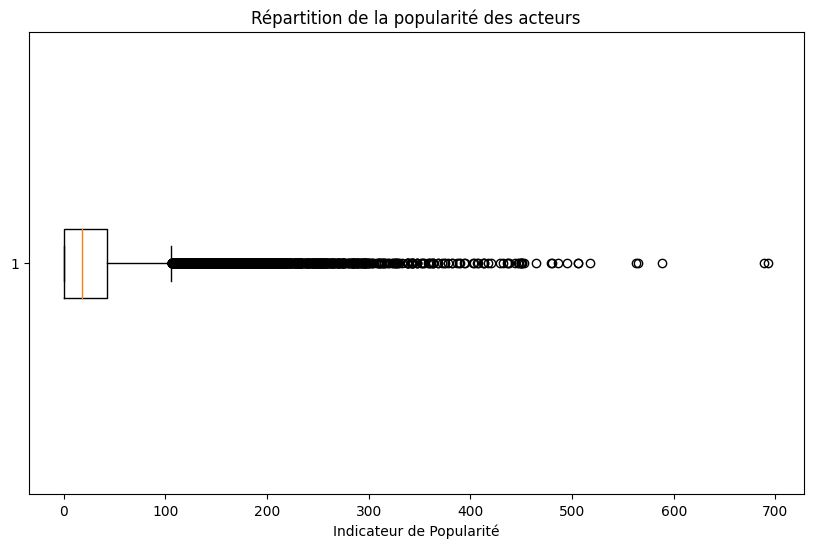

Nombre d'acteurs avec popularité = 0: 13769
Nombre d'acteurs avec popularité > 0: 27964


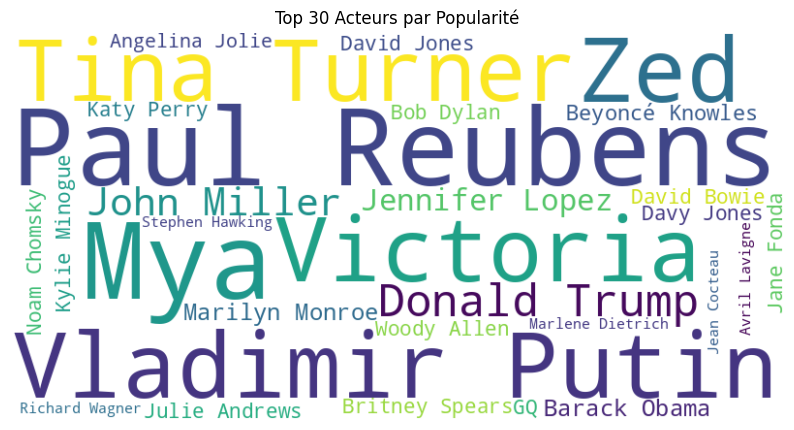

In [224]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Adapter le code pour utiliser directement actor_cache et extraire les valeurs correctes pour analyses

# Création d'un DataFrame à partir de actor_cache
df_acteurs = pd.DataFrame(list(actor_cache.items()), columns=['Nom', 'Popularité'])

# Extraction de la popularité de tous les acteurs pour le boxplot
popularite_tous_acteurs = df_acteurs['Popularité'].tolist()

# Calcul de la répartition des acteurs avec une popularité de 0 vs > 0
nombre_popularite_zero = (df_acteurs['Popularité'] == 0).sum()
nombre_popularite_plus_zero = (df_acteurs['Popularité'] > 0).sum()

# Préparation des données pour le nuage de mots des 30 acteurs les plus populaires
top_30_acteurs = df_acteurs.nlargest(30, 'Popularité')
nuage_mots_data = top_30_acteurs.set_index('Nom')['Popularité'].to_dict()

# Création du boxplot pour la répartition de la popularité
plt.figure(figsize=(10, 6))
plt.boxplot(popularite_tous_acteurs, vert=False)
plt.title('Répartition de la popularité des acteurs')
plt.xlabel('Indicateur de Popularité')
plt.show()

# Affichage du nombre d'acteurs avec popularité 0 vs > 0
print(f"Nombre d'acteurs avec popularité = 0: {nombre_popularite_zero}")
print(f"Nombre d'acteurs avec popularité > 0: {nombre_popularite_plus_zero}")

# Création et affichage du nuage de mots pour les 30 acteurs les plus populaires
plt.figure(figsize=(10, 6))
wc = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(nuage_mots_data)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Top 30 Acteurs par Popularité')
plt.show()


In [83]:
df_acteurs_sorted = df_acteurs.sort_values(by='Popularité', ascending=False)

# Afficher le DataFrame trié
df_acteurs_sorted

KeyError: 'Classe Popularité'

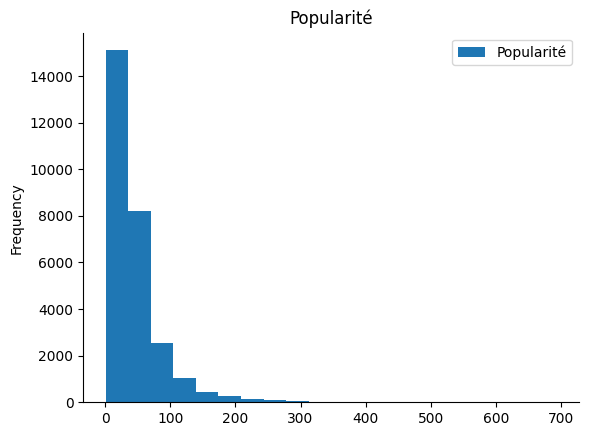

In [53]:
# @title Popularité

from matplotlib import pyplot as plt
df_acteurs_sorted[(df_acteurs_sorted['Popularité'] != 0)].plot(kind='hist', bins=20, title='Popularité')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [216]:
df_acteurs_sorted[(df_acteurs_sorted['Popularité'] > 50)]
# Création des classes de popularité dans une nouvelle colonne du DataFrame df_acteurs

# Fonction pour classifier la popularité
def classer_popularite(popularite):
    if  popularite == -1 :
        return "Non calculable"
    elif popularite >= 200:
        return "Très connu"
    elif popularite >= 100 and popularite < 200:
        return "Connu+"
    elif popularite >= 50 and popularite < 200 :
        return "Connu"
    elif popularite < 50 and popularite >= 15:
        return "Peu connu"
    elif popularite < 50 and popularite >= 15:
        return "Très peu connu"
    elif popularite == 0:
        return "Inconnu"

def classer_popularite_moy(popularite):
    if  popularite == -1 :
        return "Non calculable"
    elif popularite >= 2000:
        return "1-Très connu"
    elif popularite >= 1000 and popularite < 2000 :
        return "2-Connu"
    elif popularite < 1000 and popularite > 0:
        return "3-Peu connu"
    elif popularite == 0:
        return "Inconnu"

# Appliquer la fonction de classification à la colonne 'Popularité' pour créer une nouvelle colonne 'Classe Popularité'
df_acteurs['Classe Popularité'] = df_acteurs['Popularité'].apply(classer_popularite)

# Afficher les premières lignes du DataFrame pour vérifier
df_acteurs.head()
df_acteurs_sorted[(df_acteurs_sorted['Nom'] == "Brad Pitt")]

,Nom,Popularité
11309,Brad Pitt,277


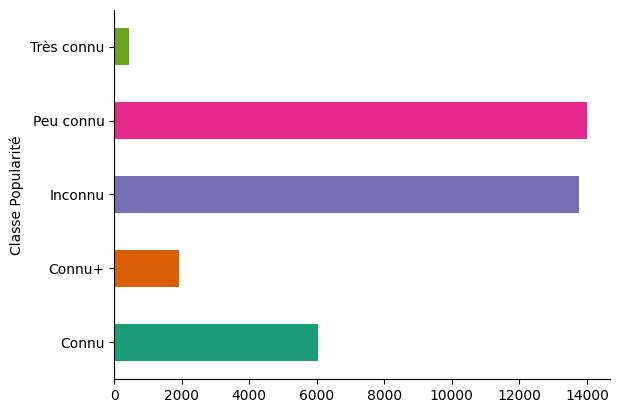

In [204]:
# @title Classe Popularité

from matplotlib import pyplot as plt
import seaborn as sns
df_acteurs.groupby('Classe Popularité').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [183]:
df_acteurs[(df_acteurs["Classe Popularité"] == "Connu+")].sort_values(by='Popularité', ascending=False)

,Nom,Popularité,Classe Popularité
6054,Kevin Costner,199,Connu+
840,Bud Spencer,199,Connu+
1849,Sienna Miller,199,Connu+
35987,Simone Signoret,199,Connu+
318,Dustin Hoffman,199,Connu+
...,...,...,...
11964,Creighton Chaney,100,Connu+
29524,Shaun White,100,Connu+
3641,Dee Bradley Baker,100,Connu+
17615,Herbert Marshall,100,Connu+


In [184]:
df = pd.read_csv('/content/drive/MyDrive/celebrity2.csv')

df.head()

,actors,actors_celebrity
0,"Logan Lerman, Brandon T. Jackson, Alexandra Da...","[('Logan Lerman', 97), ('Brandon T. Jackson', ..."
1,"Catherine Keener, Amanda Peet, Oliver Platt, R...","[('Catherine Keener', 136), ('Amanda Peet', 20..."
2,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...","[('Dudley Moore', 149), ('Bo Derek', 119), ('J..."
3,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....","[('Martin Balsam', 145), ('John Fiedler', 102)..."
4,"James Mason, Kirk Douglas, Paul Lukas, Peter L...","[('James Mason', 159), ('Kirk Douglas', 253), ..."


In [217]:
import ast
# Fonction pour trouver la classe de popularité de l'acteur le plus populaire
def classe_popularite_max(actors_celebrity):
    popularite_max = -1
    actors_celebrity_list = ast.literal_eval(actors_celebrity)
    for acteur in actors_celebrity_list:
        # Ajoutons des points de contrôle pour voir les valeurs traitées
        if isinstance(acteur, tuple) and len(acteur) == 2:
            _, popularite = acteur
            if isinstance(popularite, int) and popularite > popularite_max:
                popularite_max = popularite
        else:
            print(f"Format inattendu pour l'acteur : {acteur}")
            continue
    return classer_popularite(popularite_max)

def classe_popularite_somme(actors_celebrity):
    somme = 0
    actors_celebrity_list = ast.literal_eval(actors_celebrity)
    for acteur in actors_celebrity_list:
        # Ajoutons des points de contrôle pour voir les valeurs traitées
        if isinstance(acteur, tuple) and len(acteur) == 2:
            _, popularite = acteur
            if isinstance(popularite, int) :
                somme += popularite
        else:
            print(f"Format inattendu pour l'acteur : {acteur}")
            continue
    return somme

def classe_popularite_mean(actors_celebrity):
    somme = 0
    actors_celebrity_list = ast.literal_eval(actors_celebrity)
    if actors_celebrity_list == [] :
      actors_celebrity_list = [""]
    for acteur in actors_celebrity_list:
        # Ajoutons des points de contrôle pour voir les valeurs traitées
        if isinstance(acteur, tuple) and len(acteur) == 2:
            _, popularite = acteur
            if isinstance(popularite, int) :
                somme += popularite
        else:
            print(f"Format inattendu pour l'acteur : {acteur}")
            continue
    return somme / len(actors_celebrity_list)

def classe_popularite_mean2(actors_celebrity):
    somme = 0
    actors_celebrity_list = ast.literal_eval(actors_celebrity)
    if actors_celebrity_list == [] :
      actors_celebrity_list = [""]
    for acteur in actors_celebrity_list:
        # Ajoutons des points de contrôle pour voir les valeurs traitées
        if isinstance(acteur, tuple) and len(acteur) == 2:
            _, popularite = acteur
            if isinstance(popularite, int) :
                somme += popularite
        else:
            print(f"Format inattendu pour l'acteur : {acteur}")
            continue
    return classer_popularite_moy(somme)

# Vous pouvez ensuite appliquer la fonction pour déterminer la classe de popularité maximale
df['Classe Popularité Max'] = df['actors_celebrity'].apply(classe_popularite_max)


df['I Popularité Somme'] = df['actors_celebrity'].apply(classe_popularite_somme)

df['I Popularité Moy'] = df['actors_celebrity'].apply(classe_popularite_mean)

df['Classe Popularité Somme'] = df['actors_celebrity'].apply(classe_popularite_mean2)


# Vérifier les résultats
df[df["Classe Popularité Max"]=="Très connu"]



Format inattendu pour l'acteur : 
Format inattendu pour l'acteur : 


,actors,actors_celebrity,Classe Popularité Max,I Popularité Somme,I Popularité Moy,Classe Popularité Somme
0,"Logan Lerman, Brandon T. Jackson, Alexandra Da...","[('Logan Lerman', 97), ('Brandon T. Jackson', ...",Très connu,3022,34.735632,1-Très connu
1,"Catherine Keener, Amanda Peet, Oliver Platt, R...","[('Catherine Keener', 136), ('Amanda Peet', 20...",Très connu,788,98.500000,3-Peu connu
2,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...","[('Dudley Moore', 149), ('Bo Derek', 119), ('J...",Très connu,1967,42.760870,2-Connu
3,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....","[('Martin Balsam', 145), ('John Fiedler', 102)...",Très connu,1528,95.500000,2-Connu
4,"James Mason, Kirk Douglas, Paul Lukas, Peter L...","[('James Mason', 159), ('Kirk Douglas', 253), ...",Très connu,1140,71.250000,2-Connu
...,...,...,...,...,...,...
1988,"Nick Nolte, Eddie Murphy, Annette O'Toole, Fra...","[('Nick Nolte', 147), ('Eddie Murphy', 251), (...",Très connu,2006,35.821429,1-Très connu
1989,"Richard George, Eric Portman, Raymond Lovell, ...","[('Richard George', 11), ('Eric Portman', 57),...",Très connu,1253,56.954545,2-Connu
1992,"Chris McNair, Maxine McNair, Helen Pegues, Que...","[('Chris McNair', 12), ('Maxine McNair', 0), (...",Très connu,1525,31.770833,2-Connu
1993,"Kelly Blatz, Richard Jenkins, Kim Basinger, Ca...","[('Kelly Blatz', 45), ('Richard Jenkins', 221)...",Très connu,835,33.400000,3-Peu connu


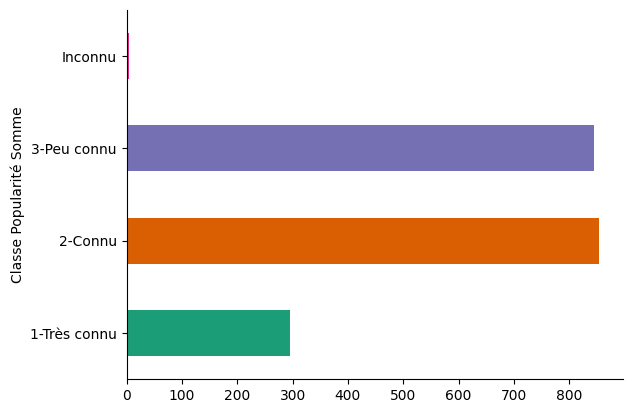

In [218]:
# @title Classe Popularité

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Classe Popularité Somme').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [220]:
dataALYA = pd.read_csv('/content/reviews_realcomplete.csv', sep=";", engine='python', on_bad_lines="skip", encoding='ISO-8859-1')

merged_df = pd.merge(dataALYA, df, left_on='actors', right_on='actors')

merged_df.columns

Index(['rotten_tomatoes_link', 'critic_name', 'top_critic', 'publisher_name',
       'review_type', 'review_score', 'review_date', 'review_content',
       'movie_title', 'movie_info', 'critics_consensus', 'content_rating',
       'genres', 'directors', 'authors', 'actors', 'original_release_date',
       'streaming_release_date', 'runtime', 'production_company',
       'tomatometer_status', 'tomatometer_rating', 'tomatometer_count',
       'audience_status', 'audience_rating', 'audience_count',
       'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
       'tomatometer_rotten_critics_count', 'sentiment', 'primary_genre',
       'actors_celebrity', 'Classe Popularité Max', 'I Popularité Somme',
       'I Popularité Moy', 'Classe Popularité Somme'],
      dtype='object')

In [230]:
import plotly.graph_objs as go

# Supposons que merged_df est déjà défini

# Créer les listes de genres uniques et de sentiments
genres = merged_df['Classe Popularité Somme'].unique().tolist()
sentiments = merged_df['sentiment'].unique().tolist()
labels = ['All reviews'] + genres + sentiments

# Initialiser les sources, cibles, et valeurs
sources = []
targets = []
values = []

# Ajouter les pourcentages aux labels
link_labels = []

# Nombre total de reviews
total_reviews = len(merged_df)

# Lien de "All Reviews" à chaque genre
all_reviews_index = labels.index('All reviews')
for genre in genres:
    genre_index = labels.index(genre)
    count = len(merged_df[merged_df['Classe Popularité Somme'] == genre])
    sources.append(all_reviews_index)
    targets.append(genre_index)
    values.append(count)
    percentage = (count / total_reviews) * 100
    link_labels.append(f"{percentage:.2f}%")

# Liens de chaque genre au sentiment
for genre in genres:
    genre_index = labels.index(genre)
    for sentiment in sentiments:
        sentiment_index = labels.index(sentiment)
        count = len(merged_df[(merged_df['Classe Popularité Somme'] == genre) & (merged_df['sentiment'] == sentiment)])
        if count > 0:
            sources.append(genre_index)
            targets.append(sentiment_index)
            values.append(count)
            percentage = (count / total_reviews) * 100
            link_labels.append(f"{percentage:.2f}%")

# Création du diagramme de Sankey avec pourcentages dans les labels des liens
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color='black', width=0.5),
      label=labels,
    ),
    link=dict(
      source=sources,
      target=targets,
      value=values,
      label=link_labels  # Ajouter les labels des liens avec pourcentages
    ))])

fig.update_layout(title_text="Sankey Diagram of Review Sentiments by Primary Genre", font_size=10)
fig.show()


In [191]:
import plotly.graph_objs as go

# Créer des labels uniques pour les noeuds.
popularite_classes = merged_df['Classe Popularité Somme'].unique().tolist()
review_types = merged_df['review_type'].unique().tolist()
labels = ['All Reviews'] + popularite_classes + review_types

# Créer des listes pour définir les sources, cibles et valeurs des liens du diagramme de Sankey.
sources = []
targets = []
values = []

# Lien de "All Reviews" à chaque classe de popularité
all_reviews_index = labels.index('All Reviews')
for classe in popularite_classes:
    classe_index = labels.index(classe)
    count = len(merged_df[merged_df['Classe Popularité Somme'] == classe])
    sources.append(all_reviews_index)
    targets.append(classe_index)
    values.append(count)

# Liens de chaque classe de popularité au type d'avis (review_type)
for classe in popularite_classes:
    classe_index = labels.index(classe)
    for review_type in review_types:
        review_type_index = labels.index(review_type)
        count = len(merged_df[(merged_df['Classe Popularité Somme'] == classe) & (merged_df['review_type'] == review_type)])
        if count > 0:
            sources.append(classe_index)
            targets.append(review_type_index)
            values.append(count)

# Créer et afficher le diagramme de Sankey.
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color='black', width=0.5),
      label=labels,
    ),
    link=dict(
      source=sources,  # indices correspondant aux labels
      target=targets,  # indices correspondant aux labels
      value=values  # valeurs correspondant aux liens
    ))])

fig.update_layout(title_text="Sankey Diagram of Review Types by Popularity Class", font_size=10)
fig.show()


In [195]:
# Supposons que 'df_acteurs' et 'merged_df' sont vos DataFrames et qu'ils ont été préalablement définis.

# Créer une nouvelle colonne pour chaque genre primaire dans df_acteurs et initialiser à 0.
for genre in merged_df['primary_genre'].unique():
    df_acteurs[genre] = 0

# Parcourir chaque ligne de merged_df et incrémenter le compteur du genre primaire associé à l'acteur dans df_acteurs
for index, row in merged_df.iterrows():
    # Cela suppose que merged_df['actors'] est une chaîne contenant les noms des acteurs séparés par une certaine délimitation, par exemple une virgule.
    actors_in_row = row['actors'].split(', ')  # ou la délimitation appropriée pour votre dataset
    primary_genre = row['primary_genre']
    for actor in actors_in_row:
        # Si l'acteur est dans df_acteurs, incrémentez la valeur du genre primaire.
        if actor in df_acteurs['Nom'].values:
            df_acteurs.loc[df_acteurs['Nom'] == actor, primary_genre] += 1

# Afficher les premières lignes pour vérifier le résultat
df_acteurs.head()


AttributeError: 'float' object has no attribute 'split'

In [222]:
import plotly.graph_objs as go
import pandas as pd

# Convertir la colonne 'original_release_date' au format datetime
merged_df['original_release_date'] = pd.to_datetime(merged_df['original_release_date'], format='%d/%m/%Y')

# Créer deux DataFrames séparés basés sur l'année
before_2000 = merged_df[merged_df['original_release_date'].dt.year < 2000]
after_2000 = merged_df[merged_df['original_release_date'].dt.year >= 2000]

# Fonction pour créer un diagramme de Sankey
def create_sankey(df, title):
    genres = df['sentiment'].unique().tolist()
    sentiments = df['primary_genre'].unique().tolist()
    labels = ['All actors'] + genres + sentiments

    # Créer les sources, cibles et valeurs pour les liens
    sources = []
    targets = []
    values = []

    all_actors_index = labels.index('All actors')
    for genre in genres:
        genre_index = labels.index(genre)
        count = len(df[df['sentiment'] == genre])
        sources.append(all_actors_index)
        targets.append(genre_index)
        values.append(count)

    for genre in genres:
        genre_index = labels.index(genre)
        for sentiment in sentiments:
            sentiment_index = labels.index(sentiment)
            count = len(df[(df['sentiment'] == genre) & (df['primary_genre'] == sentiment)])
            if count > 0:
                sources.append(genre_index)
                targets.append(sentiment_index)
                values.append(count)

    # Créer le diagramme de Sankey
    fig = go.Figure(data=[go.Sankey(
        node=dict(
          pad=15,
          thickness=20,
          line=dict(color='black', width=0.5),
          label=labels,
        ),
        link=dict(
          source=sources,
          target=targets,
          value=values
        ))])

    fig.update_layout(title_text=title, font_size=10)
    return fig

# Créer et afficher les diagrammes de Sankey pour avant et après 2000
fig_before_2000 = create_sankey(before_2000, "Sankey Diagram Before 2000")
fig_after_2000 = create_sankey(after_2000, "Sankey Diagram After 2000")

# Affichage des figures (dans un notebook Jupyter, utilisez fig.show())
fig_before_2000.show()
fig_after_2000.show()
